<a href="https://colab.research.google.com/github/liminovna/HSE_NLP_ASSIGNMENTS/blob/main/module3_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание № 9

## Задание 1 (10 баллов).
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs_torch.ipynb

На датасете lenta_sample.ru  дообучите две модели - modernbert-base (из семинара) и rumodernbert-base (https://huggingface.co/deepvk/RuModernBERT-base). Оцените разницу в качестве сравнив поклассовые метрики (classification_report)

Для обоих моделей качество должно быть >0.10 по f-мере (прогоните несколько экспериментов если у вас получаются нули, изменяя параметры).
Также для обоих моделей попробуйте дообучать модель и целиком и дообучать только последний слой.
Для RuModernBERT дополнительно сравните модель, которая использует первый вектор (cls токен, как в семинаре), так и усредненный вектор по всем hidden_state, который выдает bert.




In [2]:
! wget https://github.com/mannefedov/compling_nlp_hse_course/raw/master/notebooks/transfer_learning_hg/lenta_sample.csv

--2025-03-23 15:39:34--  https://github.com/mannefedov/compling_nlp_hse_course/raw/master/notebooks/transfer_learning_hg/lenta_sample.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/transfer_learning_hg/lenta_sample.csv [following]
--2025-03-23 15:39:35--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/transfer_learning_hg/lenta_sample.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1628490 (1.6M) [text/plain]
Saving to: ‘lenta_sample.csv.2’

lenta_sample.csv.2  100%[===================>]   1.55M  

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('lenta_sample.csv')
df

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2010/12/16/passports/,Московская милиция ужесточила паспортный режим,В Москве после серии массовых беспорядков на н...,Россия,Все,2010/12/16
1,https://lenta.ru/news/2014/05/19/student/,Московского студента ограбили на 6 миллионов р...,Неизвестные вынесли из квартиры московского ст...,Россия,NaN,2014/05/19
2,https://lenta.ru/news/2008/09/27/catch/,В Ставропольском крае обезврежены боевики,"В Ставропольском крае задержаны боевики, котор...",Россия,Все,2008/09/27
3,https://lenta.ru/news/2009/07/23/refuse/,Лужков отказался трудоустраивать китайцев с Че...,"Мэр Москвы Юрий Лужков заявил, что не намерен ...",Россия,Все,2009/07/23
4,https://lenta.ru/news/2012/09/29/factory/,По факту пожара на заводе в Югре заведено дело,Следственный комитет России возбудил уголовное...,Россия,Все,2012/09/29
...,...,...,...,...,...,...
602,https://lenta.ru/news/2014/09/14/pattern/,1914. Выкройки для раненых,"В дополнение к выкройкам белья для раненых, ра...",Библиотека,Первая мировая,2014/09/14
603,https://lenta.ru/news/2014/12/23/christmas/,1914. Немецкие и британские солдаты отметили п...,24 декабря в Бельгии в районе Ипра произошло н...,Библиотека,Первая мировая,2014/12/23
604,https://lenta.ru/news/2014/10/21/dobrovolec/,1914. Польский доброволец-герой,В числе поступивших в нашу армию добровольцев ...,Библиотека,Первая мировая,2014/10/21
605,https://lenta.ru/news/2014/09/18/postoffice/,1914. Письма в действующую армию на деревню де...,За последнее время на имя начальника штаба Вер...,Библиотека,Первая мировая,2014/09/18


In [6]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.8.0


In [7]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

from tqdm.auto import tqdm
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [9]:
def predict(model, iterator):

    preds = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:
            predictions = model(texts.to(device)).squeeze()
            ys = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            preds.extend(ys)

    return preds

In [10]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):

        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)

        self.MAX_LEN = MAX_LEN
        self.length = len(texts)

        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [11]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):

    epoch_loss = []
    epoch_f1 = []

    model.train()

    for i, (texts, ys) in enumerate(iterator):

        optimizer.zero_grad()
        predictions = model(texts.to(device)).squeeze()
        loss = criterion(predictions, ys.to(device))



        loss.backward()
        optimizer.step()
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()

        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))

        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')

    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):

    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:

            predictions = model(texts.to(device)).squeeze()
            loss = criterion(predictions, ys.to(device))
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()


            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average="micro"))

    return np.mean(epoch_f1)# / len(iterator)

In [12]:
MAX_LEN = 512

In [13]:
texts = df.text.values
id2label = {i:l for i,l in enumerate(set(df.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in df.topic]

In [14]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [15]:
import torch.nn as nn

class CLF(nn.Module):

    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        #
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(1)

    def forward(self, texts):

        mask = (texts != tokenizer.pad_token_id).long()

        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        # берем самое первое состояние и применяем к нему линейный слой и активацию
        dense_outputs=self.fc(self.drop(hidden[:,0] ))
        outputs=self.act(dense_outputs)

        return outputs

### modernbert-base

#### Дообучение с заморозкой

In [15]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

for param in model_bert.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [16]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [19]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.12916666666666665
1
Eval -  0.16458333333333333
2
Eval -  0.16041666666666665
3
Eval -  0.225
4
Eval -  0.15833333333333333
5
Eval -  0.19375
6
Eval -  0.15833333333333333
7
Eval -  0.19375
8
Eval -  0.19583333333333333
9
Eval -  0.16041666666666665


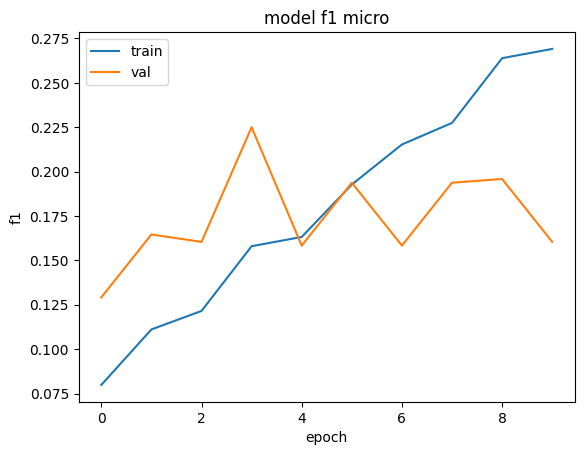

In [20]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [22]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         2
           8       0.33      1.00      0.50         1
           9       0.50      0.25      0.33         4
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2
          14       0.33      0.50      0.40         2
          16       0.50      0.40      0.44         5

    accuracy                           0.16        31
   macro avg       0.12      0.15      0.12        31
weighted avg       0.18      0.16      0.16        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

#### Дообучение без заморозки

In [23]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [25]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.12903225806451613
1
Eval -  0.06451612903225806
2
Eval -  0.12903225806451613
3
Eval -  0.16129032258064516
4
Eval -  0.16129032258064516
5
Eval -  0.16129032258064516
6
Eval -  0.25806451612903225
7
Eval -  0.2903225806451613
8
Eval -  0.25806451612903225
9
Eval -  0.16129032258064516


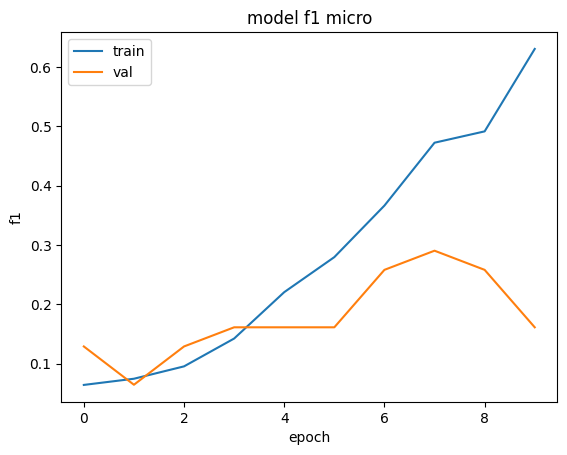

In [26]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [28]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         2
           4       0.25      1.00      0.40         1
           5       0.00      0.00      0.00         2
           6       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         2
           8       0.20      1.00      0.33         1
           9       0.25      0.25      0.25         4
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2
          14       0.50      0.50      0.50         2
          16       0.00      0.00      0.00         5

    accuracy                           0.16        31
   macro avg       0.16      0.22      0.14        31
weighted avg       0.18      0.16      0.14        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

### rumodernbert-base

#### Дообучение с заморозкой

In [29]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

for param in model_bert.parameters():
    param.requires_grad = False

tokenizer_config.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.75M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [30]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [39]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.06451612903225806
1
Eval -  0.12903225806451613
2
Eval -  0.06451612903225806
3
Eval -  0.1935483870967742
4
Eval -  0.16129032258064516
5
Eval -  0.22580645161290322
6
Eval -  0.3225806451612903
7
Eval -  0.1935483870967742
8
Eval -  0.3225806451612903
9
Eval -  0.3548387096774194
10
Eval -  0.3548387096774194
11
Eval -  0.3548387096774194
12
Eval -  0.3548387096774194
13
Eval -  0.3870967741935484
14
Eval -  0.25806451612903225
15
Eval -  0.3225806451612903
16
Eval -  0.3870967741935484
17
Eval -  0.41935483870967744
18
Eval -  0.3548387096774194
19
Eval -  0.3870967741935484
20
Eval -  0.4838709677419355
21
Eval -  0.41935483870967744
22
Eval -  0.4838709677419355
23
Eval -  0.2903225806451613
24
Eval -  0.3870967741935484
25
Eval -  0.41935483870967744
26
Eval -  0.45161290322580644
27
Eval -  0.45161290322580644
28
Eval -  0.3870967741935484
29
Eval -  0.3870967741935484


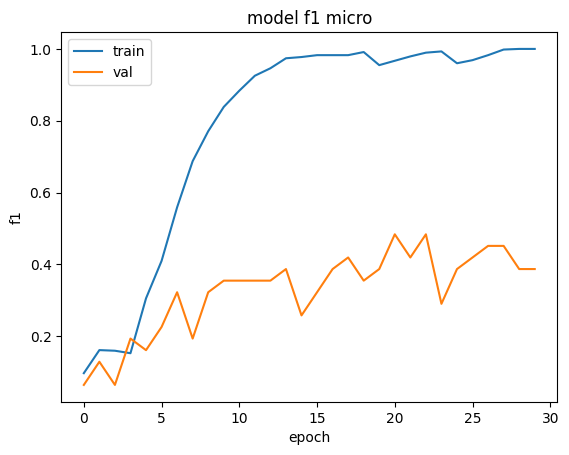

In [43]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [45]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           2       0.50      0.50      0.50         2
           3       0.00      0.00      0.00         0
           4       1.00      1.00      1.00         1
           5       0.50      1.00      0.67         2
           6       0.50      0.33      0.40         3
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       1.00      0.50      0.67         4
          10       0.17      1.00      0.29         1
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2
          14       1.00      1.00      1.00         2
          16       0.00      0.00      0.00         5

    accuracy                           0.39        31
   macro avg       0.38      0.40      0.35        31
weighted avg       0.44   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

#### Дообучение без заморозки

In [46]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [48]:
f1s = []
f1s_eval = []

for i in range(20):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.3870967741935484
1
Eval -  0.5483870967741935
2
Eval -  0.5161290322580645
3
Eval -  0.5483870967741935
4
Eval -  0.6129032258064516
5
Eval -  0.4838709677419355
6
Eval -  0.5483870967741935
7
Eval -  0.5806451612903226
8
Eval -  0.5161290322580645
9
Eval -  0.5806451612903226
10
Eval -  0.5806451612903226
11
Eval -  0.5806451612903226
12
Eval -  0.5806451612903226
13
Eval -  0.5806451612903226
14
Eval -  0.5806451612903226
15
Eval -  0.5806451612903226
16
Eval -  0.5806451612903226
17
Eval -  0.5806451612903226
18
Eval -  0.5806451612903226
19
Eval -  0.5483870967741935


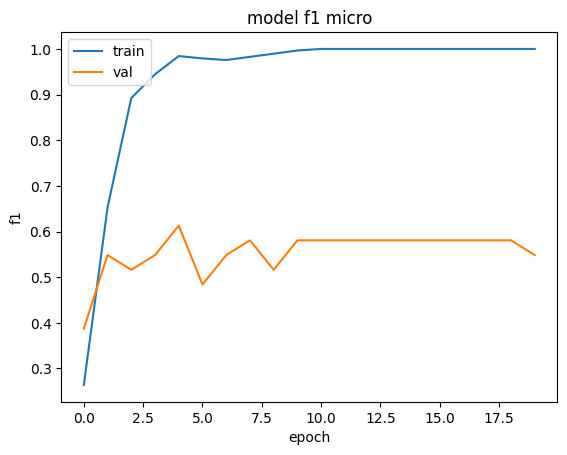

In [49]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [51]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         2
           4       1.00      1.00      1.00         1
           5       0.67      1.00      0.80         2
           6       0.67      0.67      0.67         3
           7       1.00      0.50      0.67         2
           8       0.00      0.00      0.00         1
           9       1.00      0.75      0.86         4
          10       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2
          14       1.00      1.00      1.00         2
          16       0.60      0.60      0.60         5

    accuracy                           0.55        31
   macro avg       0.54      0.51      0.52        31
weighted avg       0.59      0.55      0.56        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

#### Усредненный вектор по всем hidden state

Не получилось реализовать

In [22]:
import torch.nn as nn

class CLF_HSMean(nn.Module):

    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        #
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(1)

    def forward(self, texts):

        mask = (texts != tokenizer.pad_token_id).long()

        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask, output_hidden_states=True) # добавляем параметр output_hidden_states
        hs = hidden.hidden_states[1:]

        hs_mean = torch.mean(hs)

        # берем самое первое состояние и применяем к нему линейный слой и активацию
        dense_outputs=self.fc(self.drop(hs_mean))
        outputs=self.act(dense_outputs)

        return outputs

In [23]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

In [24]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF_HSMean(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [26]:
f1s = []
f1s_eval = []

for i in range(20):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0


OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 22.12 MiB is free. Process 758373 has 14.72 GiB memory in use. Of the allocated memory 14.58 GiB is allocated by PyTorch, and 15.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))